# IBM Open Science Prize 2022 

**Group:** _Stefan Sack, Stefano Barison_

In [1]:
## TODO: little introduction?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1 - Classical simulation 

In [3]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [4]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

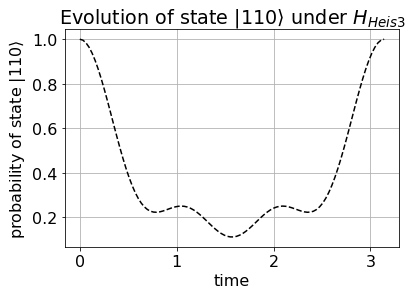

In [5]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110_exact = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

## 2- The Open Science Prize

The aim is to time evolve the state $|110\rangle$ to time $t=\pi$ under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$. The evolution must be done using Trotterization with at least 4 steps ($n\geq4$).

### 2.1 - Trotterization comparison

For this reason, we will start analysing how a Trotterization on a perfect quantum device will evolve the state $|110\rangle$ to time $t=\pi$ given a fixed number of Trotter steps.

In [6]:
## Import functions from Qiskit
from qiskit                     import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.providers.aer       import QasmSimulator
from qiskit.tools.monitor       import job_monitor
from qiskit.circuit             import Parameter, ParameterVector
from qiskit.quantum_info        import Statevector, Pauli
from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import PauliOp, SummedOp, CircuitSampler, StateFn

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info                  import state_fidelity

In [7]:
## In the "trotter_function.py" file are contained all the functions useful for a perfect Trotter simulation
from trotter_functions import Heisenberg_Trotter, Heisenberg_Trotter_compressed

In [8]:
## Let's simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
t_steps = [4,8,12]
probs_110_trott = {4:[],8:[],12:[]}
t = Parameter("t")

for t_n in t_steps:
    for sim_t in ts:
        # Initialise the circuit
        trott_qr = QuantumRegister(3)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x([1,2])
    
        # Append the Trotterization
        trott_step = Heisenberg_Trotter(num_qubits=3,trotter_steps=t_n,p=t,target_time=sim_t).to_instruction()
        trott_qc.append(trott_step, [trott_qr[0], trott_qr[1], trott_qr[2]])
    
    
        trott_wfn = CircuitStateFn(trott_qc)
        trott_ovp = np.abs((~initial_state@trott_wfn).eval())**2
        probs_110_trott[t_n].append(trott_ovp)
    print(str(t_n)+" steps completed")

4 steps completed
8 steps completed
12 steps completed


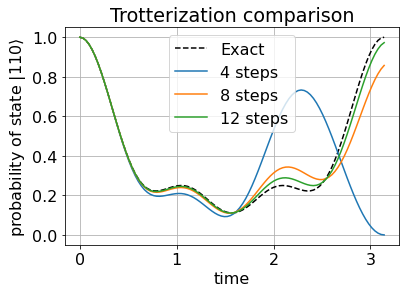

In [9]:
# Now plot the comparison
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
for (i,t_n) in enumerate(t_steps):
    plt.plot(ts, probs_110_trott[t_n],color="C"+str(i),label=str(t_n)+" steps")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Trotterization comparison')
plt.legend()
plt.grid()
plt.show()

As we can see, four Trotter steps are not enough to correctly time evolve the target state to $t=\pi$.
As expected, increasing the Trotter steps we get closer and closer to the exact simulation.

However, we are limited in the circuit depth that we can implement on hardware. For this reason, the aim of this notebook will be to compress the greatest Trotterization accuracy into the shortest possible circuit, before even applying error mitigation techniques.

### 2.2 Compress the Trotter step

The first step is to reduce the number of gates required by a single Trotter step. 
To this point, a single Trotter step requires $12$ CNOTs.

We can easily reduce it to $6$ using an optimal circuit for the $XX+YY+ZZ$ rotation presented in [Quantum computers as universal quantum simulators: state-of-art and perspectives](https://arxiv.org/abs/1907.03505).

In particular, we will consider the decomposition in Fig. 4b, while the initial Trotterization corresponds to the decomposition in Fig. 4a.

With this decomposition, 4 Trotter steps on 3 qubits will now require 24 CNOTs instead of 48.

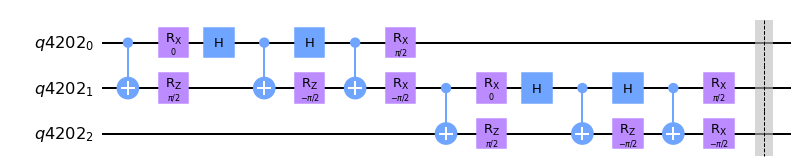

In [10]:
## Ad an example of the new Trotter step

compression_example = Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=1,p=t,target_time=np.pi/4)
compression_example.decompose().decompose().draw(output='mpl')

To show that the two decompositions are equivalent, let us simulate again the system up to $t=\pi$.

In [11]:
probs_110_trott_c = []
for sim_t in ts:
    # Initialise the circuit
    trott_qr_c = QuantumRegister(3)
    trott_qc_c = QuantumCircuit(trott_qr_c)
    trott_qc_c.x([1,2])
    
    # Append the Trotterization
    trott_step_c = Heisenberg_Trotter_compressed(num_qubits=3,trotter_steps=4,p=t,target_time=sim_t).to_instruction()
    trott_qc_c.append(trott_step_c, [trott_qr_c[0], trott_qr_c[1], trott_qr_c[2]])
    
    
    trott_wfn_c = CircuitStateFn(trott_qc_c)
    trott_ovp_c = np.abs((~initial_state@trott_wfn_c).eval())**2
    probs_110_trott_c.append(trott_ovp_c)

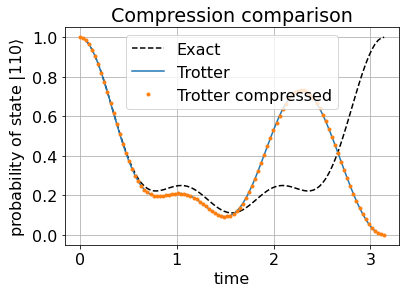

In [12]:
## Now plot the exact simulation, the initial Trotter and the Trotter compressed
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(ts, probs_110_trott[4],color="C0",label="Trotter")
plt.plot(ts, probs_110_trott_c,color="C1",marker=".",linestyle="",label="Trotter compressed")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Compression comparison')
plt.legend()
plt.grid()
plt.show()

As can be seen, the two circuits give the exact same probability at all times!

### Using the Yang - Baxter Equivalence (YBE) 

The circuit now has 24 CNOTs which is already very good, though it can be compressed even further! To this end we will be using the [Yang-Baxter Equation](https://www.worldscientific.com/doi/epdf/10.1142/S0217751X89001503) (YBE) which has recently been used by [Gulania et. al](https://arxiv.org/pdf/2112.01690.pdf) to compress the circuit for a Trotterized time evolution of the XY Heisenberg model. 

The YBE equation works in the following way:

--- Put the image of the method

Unfortunately, the paper doesn't present an analytical relationship between the Trotter circuit and the YBE-compressed circuit when considering the XXX Hamiltonian, even that is conjectured to exist.

We propose to find this equivalence variationally.

In [13]:
def Heisenberg_YBE_variational(num_qubits,p):

    circ  = QuantumCircuit(num_qubits)
    count = 0
    
    def XYZ_variational(circ,i,j,params):
        circ.cx(i,j)
        circ.rx(params[0],i)
        circ.rx(-np.pi/2,i)
        circ.h(i)
        circ.rz(params[1],j)

        circ.cx(i,j)
        circ.h(i)
        circ.rz(params[2],j)

        circ.cx(i,j)
        circ.rx(np.pi/2,i)
        circ.rx(-np.pi/2,j)

    circ.rx(np.pi,[1,2])
    
    XYZ_variational(circ,1,2,p[count:count+3])
    count += 3
    XYZ_variational(circ,0,1,p[count:count+3])
    count += 3
    XYZ_variational(circ,1,2,p[count:count+3])
    count += 3
    XYZ_variational(circ,0,1,p[count:count+3])
    count += 3
    XYZ_variational(circ,1,2,p[count:count+3])
    count += 3

    return circ

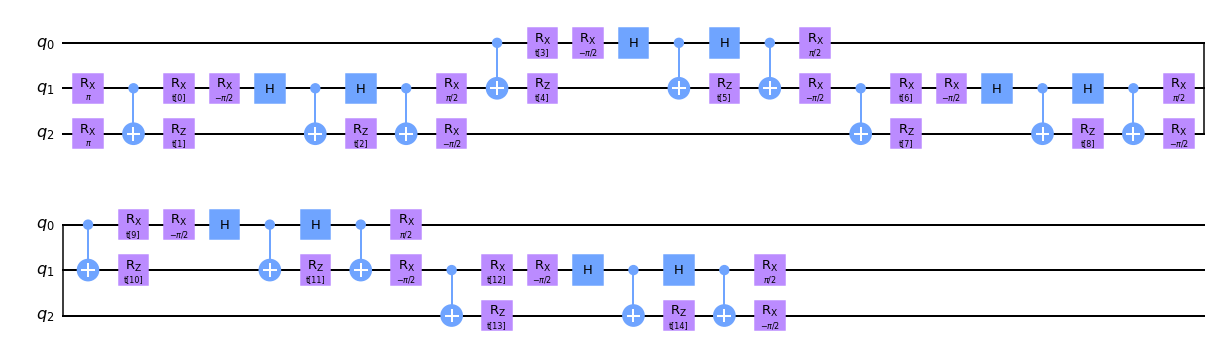

In [14]:
# Here we show an example of the circuit
example = Heisenberg_YBE_variational(3,ParameterVector('t',15))
example.draw(output='mpl')

In [ ]:
###################### Put here the optimization ######################

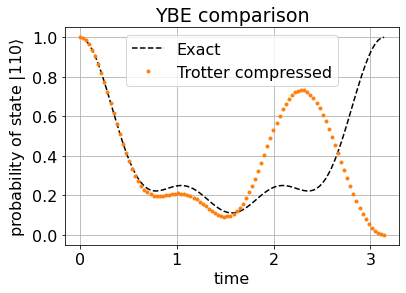

In [16]:
## Now plot the exact simulation, the initial Trotter and the Trotter compressed
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(ts, probs_110_trott_c,color="C1",marker=".",linestyle="",label="Trotter compressed")
#plt.plot(ts,,color="C0",label="YBE compression")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'YBE comparison')
plt.legend()
plt.grid()
plt.show()

As can be seen, at every time $t$ we are able to find a set of parameters that makes the YBE compressed circuit equivalent to the 24 CNOTs Trotter circuit.

From this moment on, we will be using this circuit for the challenge.

### 2.3 Variational compression - the pVQD algorithm

We want to compress more Trotter steps into the same circuit, in order to gain accuracy without adding noise due to gate error rates. This can be done by making every value of $t$ of the Trotter circuit a variational parameter and using the pVQD algorithm optimize them.

We highlight that we are not modifying the circuit, instead we are optimizing the same gates in order to make the circuit contain a more accurate state.

In [17]:
# import the function for pVQD
from pVQD import compute_overlap_and_gradient, adam_gradient, projector_zero, ei

Since we have $3$ rotations depending on $t$ for every compressed gate, this will result in a total of 24 parameters to optimize

The circuit has exactly the same gates has before (in this case we also show the initial state $|110\rangle$).

In [18]:
# Here we put the optimization loop of the pVQD algorithm
backend       = Aer.get_backend('statevector_simulator')
instance      = QuantumInstance(backend=backend)
num_qubits    = 3

parameters    = np.zeros(15)
shift         = 0.01*np.ones(15)
params_vec    = ParameterVector('p',len(parameters))


dt            = np.pi/60
max_iter      = 100
n_steps       = 60
ths           = 0.9999



## Initialize quantities that will be equal all over the calculation
num_parameters = len(parameters)
# ParameterVector for left and right circuit

left  = ParameterVector('l', num_parameters)
right = ParameterVector('r', num_parameters)


## initialize useful quantities once
expectation = PauliExpectation()
sampler     = CircuitSampler(instance)

## Now prepare the state in order to compute the overlap and its gradient
# First use a single compressed Trotter step
U_dt      = Heisenberg_Trotter_compressed(num_qubits,1,t,dt)
ansatz    = Heisenberg_YBE_variational(num_qubits,params_vec)

# Then, create the total circuit

l_circ     = ansatz.assign_parameters({params_vec: left})
r_circ     = ansatz.assign_parameters({params_vec: right})
zero_prj   = StateFn(projector_zero(U_dt.num_qubits),is_measurement = True)
total_circ = r_circ.compose(U_dt)+l_circ.inverse()
state_wfn  = expectation.convert(zero_prj @ StateFn(total_circ))

#######################################################

In [19]:
times = [i*dt for i in range(n_steps+1)]
tot_steps= 0
print("Running the algorithm")

pvqd_params = []
pvqd_params.append(list(parameters))


for i in range(n_steps):

    print('\n================================== \n')
    print("Time slice:",i+1)
    print("Shift before optimizing this step:",shift)
    print("Initial parameters:", parameters)
    print('\n================================== \n')

    count = 0
    overlap = [0.01,0]

    # Initialise quantities for the Adam optimiser
    m = np.zeros(num_parameters)
    v = np.zeros(num_parameters)


    while overlap[0] < ths and count < max_iter:
        print("Shift optimizing step:",count+1)
        count = count +1 

        ## Measure energy and gradient

        E,g = compute_overlap_and_gradient(left,right,state_wfn,parameters,shift,expectation,sampler)
        tot_steps = tot_steps+1


        print('Overlap',E[0])
        overlap = E
        #print('Gradient',g[:,0])


        meas_grad = np.asarray(g[:,0])
        shift = np.asarray(adam_gradient(parameters,shift,count,m,v,meas_grad))


    # Update parameters

    print('\n---------------------------------- \n')

    print("Shift after optimizing:",shift)
    print("New parameters:"        ,parameters + shift)
    print("New overlap: "          ,E[0])

    parameters = parameters + shift
    pvqd_params.append(list(parameters))

Running the algorithm


Time slice: 1
Shift before optimizing this step: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01]
Initial parameters: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Shift optimizing step: 1
Overlap 0.9881904977528879
Shift optimizing step: 2
Overlap 0.9887666807538742
Shift optimizing step: 3
Overlap 0.9893166179576728
Shift optimizing step: 4
Overlap 0.9898399428658551
Shift optimizing step: 5
Overlap 0.9903364611467372
Shift optimizing step: 6
Overlap 0.9908062031220917
Shift optimizing step: 7
Overlap 0.9912494742717809
Shift optimizing step: 8
Overlap 0.9916669058296906
Shift optimizing step: 9
Overlap 0.9920594992164363
Shift optimizing step: 10
Overlap 0.9924286544090626
Shift optimizing step: 11
Overlap 0.992776169605239
Shift optimizing step: 12
Overlap 0.9931041993169214
Shift optimizing step: 13
Overlap 0.9934151623808155
Shift optimizing step: 14
Overlap 0.9937116012798998
Shift optimizing step: 15
Overlap 0.993996007829

From the pVQD routine we get a list of parameters sets.

What we are interested in is the last set of parameters, corresponding to the evolution of the wavefunction at the final time $t=\pi$.

For completeness, we will also plot the probability of geting $|110\rangle$ throught the overall evolution.

In [20]:
def measure_overlap_target(target,ansatz,param_list):

    ovp_list = []
    
    for params in param_list:
        circ  = ansatz(3,params)
        t_wfn = CircuitStateFn(circ)
        t_ovp = np.abs((~target@t_wfn).eval())**2

        ovp_list.append(t_ovp)

    return ovp_list

In [21]:
pvqd_ovps   = measure_overlap_target(One^One^Zero,Heisenberg_YBE_variational,pvqd_params)

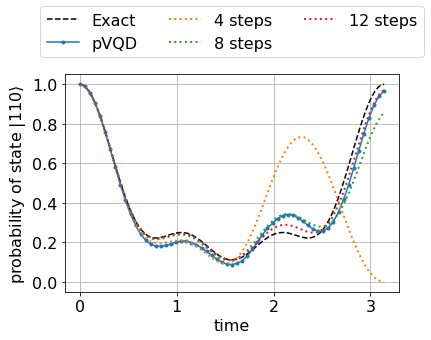

In [22]:
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(times,pvqd_ovps,label="pVQD",marker=".",color="C0")
for (i,t_n) in enumerate(t_steps):
    plt.plot(ts, probs_110_trott[t_n],color="C"+str(i+1),label=str(t_n)+" steps",linewidth=2,linestyle="dotted")

plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
#plt.title(r'pVQD performance')
plt.legend(loc="upper center",bbox_to_anchor=(0.5, 1.35),ncol=3,fancybox=True)
plt.grid()
plt.show()

As can be seen, we have an improvement through the whole simulation, not just for the final state.
At $t \sim 1.5$ the Trotter approximation with $4$ steps starts detaching from the exact simulation, while the pVQD stay closer, with performances comparable to the 12 steps approximation.

We highlight that this technique is completely general: given a Trotter step $U(dt)$ we can compress its repeated application into a variational circuit of choice.

Moreover, this technique can also be performed entirely on hardware, as shown in [this article](https://arxiv.org/pdf/2112.12654.pdf).

In [23]:
#Here we show the parameters that we are going to use 
pvqd_opt_params = pvqd_params[-1]
pvqd_opt_params

[0.6382017096925308,
 0.6000000016914803,
 0.6382017096914653,
 3.0088034724777004,
 -3.0869200238078918,
 0.4709531430380659,
 2.163149581742511,
 3.480816153370887,
 -2.0741264572900358,
 1.2330207076560198,
 3.127510103326668,
 1.5937443369823563,
 6.107319845979351,
 3.017771784637272,
 -3.2490180697350604]

In [ ]:
params_new_notebook = [0.6382017062070897,
 0.5999999987484098,
 0.6382017062066773,
 3.0088034895496003,
 -3.0869200336945677,
 0.4709531470409451,
 2.163149581322057,
 3.480816125849344,
 -2.0741264452466974,
 1.2330206913091548,
 3.1275100711382064,
 1.593744340473751,
 6.107319841483039,
 3.0177717815840808,
 -3.24901805128811]

params_opt = [0.6382017096925308,
 0.6000000016914803,
 0.6382017096914653,
 3.0088034724777004,
 -3.0869200238078918,
 0.4709531430380659,
 2.163149581742511,
 3.480816153370887,
 -2.0741264572900358,
 1.2330207076560198,
 3.127510103326668,
 1.5937443369823563,
 6.107319845979351,
 3.017771784637272,
 -3.2490180697350604]

### 2.4 Final compression

We can use the `compute_overlap_and_gradient` function from pVQD to optimize the parameters for the YBE compressed circuit.

Now we learn the right parameters

## 3- Final Implementation

### 3.1 Error mitigation

Here we will use error mitigation to further improve the result. In particular we will be using Zero Noise Extrapolation (ZNE). For this the circuit depth is extended by unfolding gates, $G \rightarrow G G^\dagger G$. The circuit remains the same this way (since $G^\dagger G = I$), though the noise is increased. This way we can obtain results for different noise levels and extrapolate to the ideal, zero noise case. This prodecure is nicely wrapped into a single function provided by [mitiq](https://mitiq.readthedocs.io/en/stable/from). One simply has to be careful with minor bugs present in mitiq, we will comment on them below. 

In [24]:
# Define an ansatz for mitiq and also for the hardware

def final_circ(parameters):

    # Define the final circuit that is used to compute the fidelity 
    fqr = QuantumRegister(7)
    fqc = QuantumCircuit(fqr)
    #fqc.rx(np.pi, [3, 5]) # Cannot use X gate due to a bug in mitq, rx(pi) does the same thing
    fqc.id([0, 1, 2, 4, 6]) # Need to put identities since mitq cannot handle unused qubits
    fqc.append(Heisenberg_YBE_variational(3,parameters), [fqr[1], fqr[3], fqr[5]])
    
    return fqc

In [25]:
# Define the final circuit that is used to compute the fidelity 
fqr = QuantumRegister(7)
fqc = QuantumCircuit(fqr)
#fqc.rx(np.pi, [3, 5]) # Cannot use X gate due to a bug in mitq, rx(pi) does the same thing
fqc.id([0, 1, 2, 4, 6]) # Need to put identities since mitq cannot handle unused qubits
fqc.append(Heisenberg_YBE_variational(3,pvqd_opt_params), [fqr[1], fqr[3], fqr[5]])

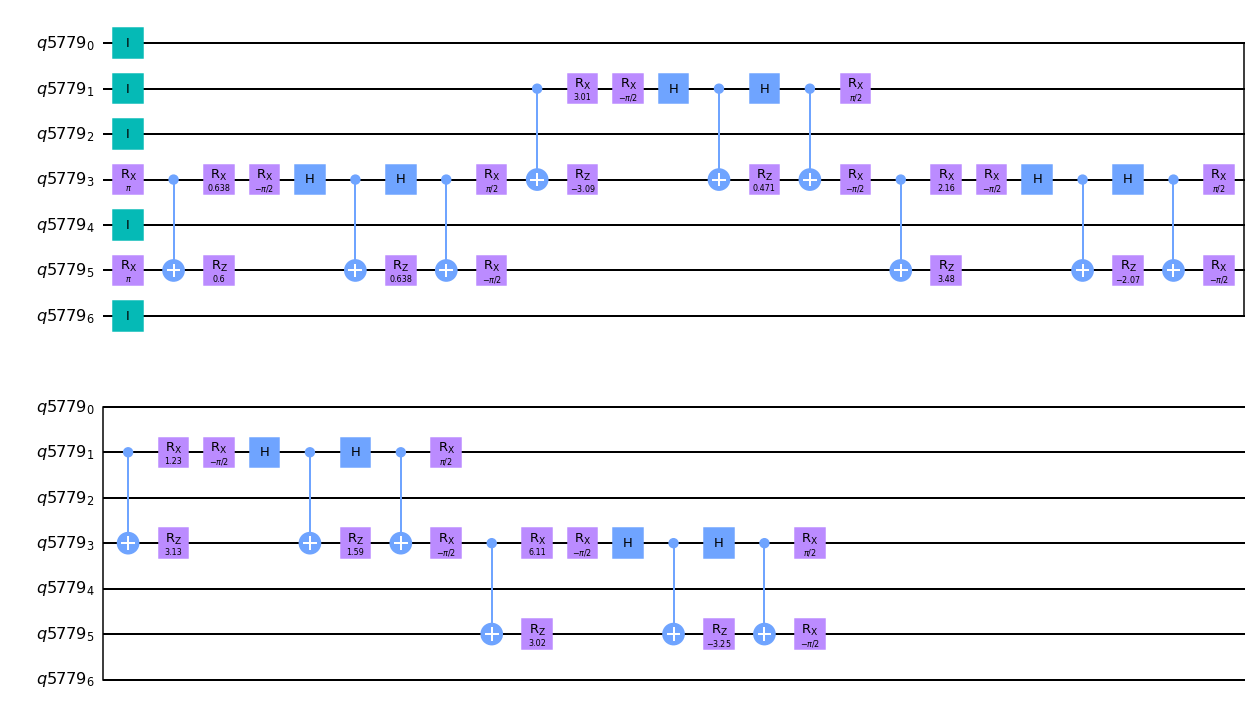

In [26]:
#fc = final_circ(ybe_optimal)
fqc.decompose().draw(output="mpl")

In [27]:
from mitiq import zne
from qiskit.result import Result
from qiskit.result.models import ExperimentResult
from qiskit.result.models import ExperimentResultData
from qiskit.result.models import QobjExperimentHeader

In [28]:
provider = IBMQ.load_account()

In [29]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
#jakarta = provider.get_backend('ibmq_jakarta')
# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

In [60]:
# Setting all the parameters that are need
shots = 8192
backend = sim_noisy_jakarta

In [31]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [71]:
def zne_results(tomo_circs, backend, optimization_level, zne_order, shots):

    # This function runs the tomography circuits and unrolls the gates to increase the noise level
    # The counts that are obtained for the differnt noise levels are then extrapolated to the zero-noise level

    zne_result_list = []
    scale_factors = [1.0, 2.0, 3.0]
    # Loop over the tomography circuits
    for circ in tomo_circs:

         # Unfold the tomography circuit by a scale factor and evaluate them 
        noise_scaled_circuits = [zne.scaling.fold_global(circ, s) for s in scale_factors]  
        result_list = [execute(circ_noise, backend=backend, optimization_level=optimization_level, shots=shots).result() for circ_noise in noise_scaled_circuits]

        counts_dict = {}
        ordered_bitstrings = dict(sorted(result_list[0].get_counts().items()))
        # Loop over the results of the scaled circuits and collect the data in the correct form
        for key in ordered_bitstrings.keys():
            counts_list = []
            for result in result_list:
                counts_list.append(result.get_counts()[key])
            # Here we extrapolate the counts to zero noise and round to the closest integer 
            zne_counts_value = int(zne.PolyFactory.extrapolate(scale_factors, counts_list, order=zne_order)) 
            if zne_counts_value < 0:
                zne_counts_value = 0
            counts_dict[key] = zne_counts_value
        zne_result_list.append(counts_dict)
        
    # To work with the StateTomographyFitter we need to put the result into a Qiskit Result() object
    name_list = [circ.name for circ in tomo_circs]
    results_tmp = [[ExperimentResult(shots=shots, success=True, data=ExperimentResultData(counts=result_i), header=QobjExperimentHeader(name=name_i))] for (name_i, result_i) in zip(name_list, zne_result_list)]
    results = [Result(backend_name="zne", backend_version="zne", qobj_id='0', job_id='0', success=True, results=result_i) for result_i in results_tmp]

    return results 


In [72]:
# Create the tomography circuits
st_qcs = state_tomography_circuits(fqc.decompose(), [fqr[1], fqr[3], fqr[5]])

In [80]:
# Repeat fidelity measurement
reps = 1 # Needs to be 8 in the final execution
fids = []
for _ in range(reps):
    
    zne_res = zne_results(st_qcs, backend=backend, optimization_level=3, zne_order=2, shots=shots)
    fids.append(state_tomo(zne_res, st_qcs)) 

In [81]:
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.9541 ± 0.0000
